In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **consommation** :

* SARIMAX avec des données métier en régresseurs exogènes
* SARIMAX sur le signal sans régresseur
* Régression linéaire sur les données métiers comme variables explicatives

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_W.csv',
                usecols = ['Dates', 'Consommation'])
df.head(1)

,Dates,Consommation
0,2013-01-06,61585.265972


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

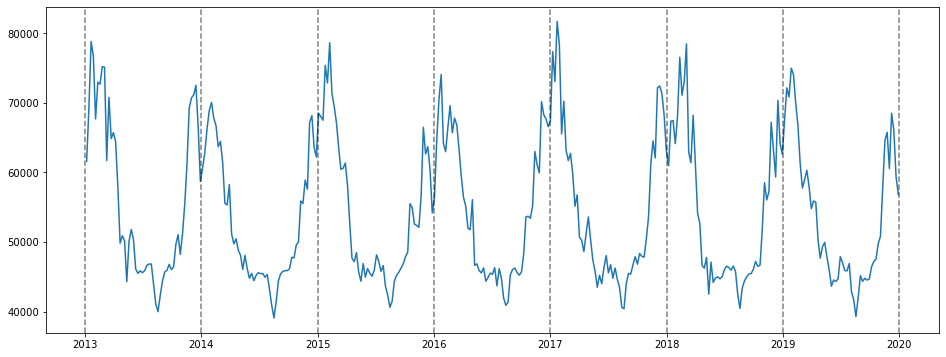

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df[(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [6]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df)

(-7.481907198206401,
 4.7479248580446297e-11,
 14,
 446,
 {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893},
 8458.941729622353)

### Coéfficients SARIMAX et saisonnalités

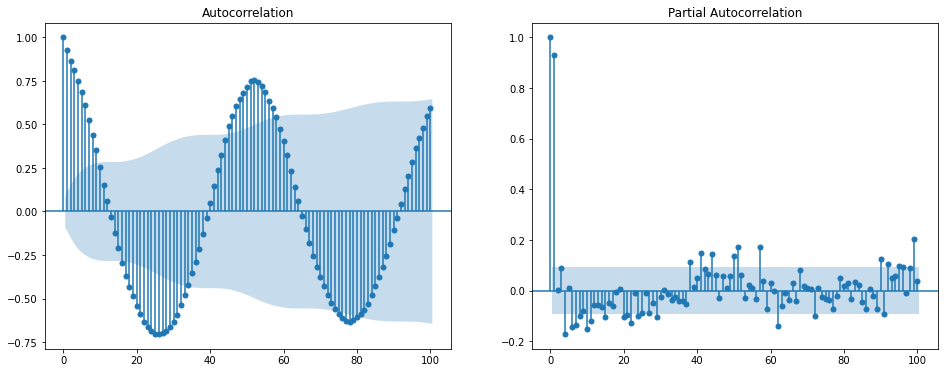

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df, lags = 100, ax=ax1)
plot_pacf(df, lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Jeux d'entrainement et de test

In [8]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [9]:
fenetre = df_test.shape[0]

In [10]:
indice = df_test.index

In [11]:
bilan = df_test

# Paramètres SARIMAX

In [12]:
ordre = (2,0,0)
saison = (1,0,0,52)

# Régresseurs exogènes : données métier

In [13]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-06,-6.990618


In [14]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [15]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [16]:
model_exog = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [17]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -3734.224
Date:                            Wed, 04 May 2022   AIC                           7478.449
Time:                                    10:34:13   BIC                           7497.948
Sample:                                         0   HQIC                          7486.198
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           995.4357    233.763      4.258      0.000     537.268    1453.603
ar.L1          0.8785      0.200      4.395      0.000       0.487       1.270
ar.L2          0.1156      0.200      0.578      0.563      -0.277       0.508
ar.S.L52       0.1216      0.119      1.022      0.307      -0.112       0.355
sigma2      1.124e+08   1.02e-05    1.1e+13      0.000    1.12e+08    1.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.98   Prob(JB):                         0.40
Heteroskedasticity (H):               1.22   Skew:                             0.08
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 7.18e+30. Standard errors may be unstable.
"""

In [19]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [20]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Conso_p_exog'])

In [21]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [22]:
bilan['Err_exog'] = np.abs(bilan['Conso_p_exog'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_exog,Err_exog
count,96.000000,96.000000,96.000000
mean,51065.938740,53498.306756,4346.589637
std,9671.134093,10405.845830,4037.065577
min,39803.035714,38802.002007,15.261770
25%,43499.698661,45270.823012,1046.951105
50%,48156.086310,49176.871957,3217.157294
75%,59246.607887,63746.104893,6350.455150
max,77322.125000,75708.848688,17329.620494


# Sans régresseur

### SARIMAX

In [23]:
model_noreg = sm.tsa.SARIMAX(df_train.values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [24]:
result_noreg = model_noreg.fit(low_memory=True)

In [25]:
result_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -3516.726
Date:                            Wed, 04 May 2022   AIC                           7041.453
Time:                                    10:34:15   BIC                           7057.052
Sample:                                         0   HQIC                          7047.652
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9067      0.056     16.234      0.000       0.797       1.016
ar.L2          0.0900      0.056      1.612      0.107      -0.019       0.199
ar.S.L52       0.2350      0.059      3.979      0.000       0.119       0.351
sigma2      1.394e+07   2.32e-10      6e+16      0.000    1.39e+07    1.39e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                45.02
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.04
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+33. Standard errors may be unstable.
"""

In [26]:
predict_noreg = result_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [27]:
predict_noreg = pd.DataFrame(predict_noreg, index = indice, columns = ['Conso_p_noreg'])

In [28]:
bilan = pd.concat([bilan, predict_noreg], axis = 1)

### Erreur absolue

In [29]:
bilan['Err_noreg'] = np.abs(bilan['Conso_p_noreg'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_exog,Err_exog,Conso_p_noreg,Err_noreg
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,51065.938740,53498.306756,4346.589637,53725.501145,4403.086070
std,9671.134093,10405.845830,4037.065577,10504.252688,4274.539960
min,39803.035714,38802.002007,15.261770,39675.442543,7.667675
25%,43499.698661,45270.823012,1046.951105,45576.008113,1360.544771
50%,48156.086310,49176.871957,3217.157294,49363.443569,2285.461276
75%,59246.607887,63746.104893,6350.455150,63484.756570,6005.539607
max,77322.125000,75708.848688,17329.620494,77719.438324,17103.838818


# Régression linéaire avec Régresseurs exogènes : données métier 

In [30]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-06,-6.990618


In [31]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [32]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [33]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train)
predict_lr = LinReg.predict(exog_test)

In [34]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Conso_p_LinReg'])

In [35]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [36]:
bilan['Err_LinReg'] = np.abs(bilan['Conso_p_LinReg'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_exog,Err_exog,Conso_p_noreg,Err_noreg,Conso_p_LinReg,Err_LinReg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,51065.938740,53498.306756,4346.589637,53725.501145,4403.086070,53238.343360,4206.222693
std,9671.134093,10405.845830,4037.065577,10504.252688,4274.539960,8983.103341,2840.085315
min,39803.035714,38802.002007,15.261770,39675.442543,7.667675,37156.855756,61.682815
25%,43499.698661,45270.823012,1046.951105,45576.008113,1360.544771,45056.352710,2247.108923
50%,48156.086310,49176.871957,3217.157294,49363.443569,2285.461276,54214.657609,3724.919301
75%,59246.607887,63746.104893,6350.455150,63484.756570,6005.539607,60696.308326,6042.487698
max,77322.125000,75708.848688,17329.620494,77719.438324,17103.838818,72736.185124,11800.850332


# Visualisation réel vs prédictions

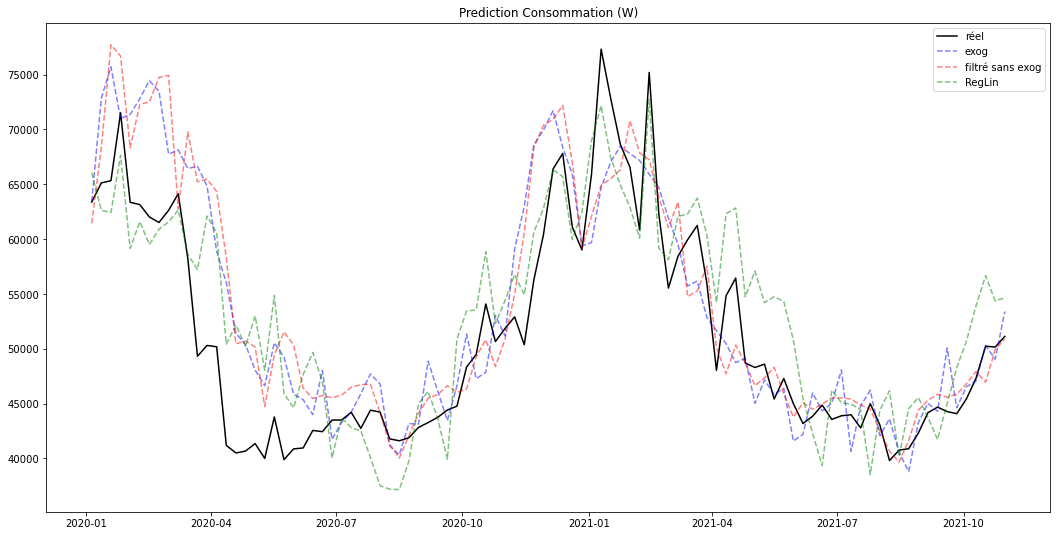

In [37]:
plt.figure(figsize=(18,9))
#plt.plot(df_train.resample('W').mean(), color = 'k')
plt.plot(bilan['Consommation'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Conso_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Conso_p_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Conso_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.legend(loc = 'upper right')
plt.title('Prediction Consommation (W)')
plt.savefig('./results/pred_consommation_W.png');

# Synthèse des erreurs

In [38]:
erreur = bilan[['Err_exog',
       'Err_noreg',
       'Err_LinReg'
      ]].describe()
erreur

,Err_exog,Err_noreg,Err_LinReg
count,96.000000,96.000000,96.000000
mean,4346.589637,4403.086070,4206.222693
std,4037.065577,4274.539960,2840.085315
min,15.261770,7.667675,61.682815
25%,1046.951105,1360.544771,2247.108923
50%,3217.157294,2285.461276,3724.919301
75%,6350.455150,6005.539607,6042.487698
max,17329.620494,17103.838818,11800.850332


In [39]:
bilan.to_csv('./results/bilan_consommation_W.csv', sep = ';')
erreur.to_csv('./results/erreur_consommation_W.csv', sep = ';')